In [29]:
import solver
import numpy as np
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

Solve the following problem:

$$
-Δu(x) = f(x) \quad \forall x \in \Omega := [a, b] \times [c, d]
$$

with the boundary condition:

$$
u(x) = 0 \quad \forall x \in \partial\Omega
$$

Focusing on:

- Using essential libraries like scipy and numpy for computations.
- Analyzing the method's convergence with a test case.
- Visualizing results using matplotlib or plotly.
- Refining meshes based on convergence theory to enhance solution accuracy.

## Step 1: Establish a suitable mesh for the rectangular domain

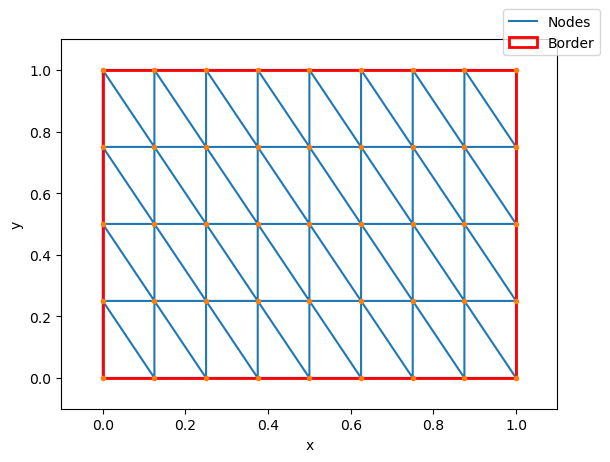

In [46]:

# Esempio di uso
a, b, c, d = 0, 1, 0, 1  # Limiti del dominio
nx, ny = 9, 5  # Numero di divisioni
nodes, elements = solver.create_rectangular_triangle_mesh(a, b, c, d, nx, ny)
boundary_nodes = solver.find_boundary_nodes(nodes, a, b, c, d)
solver.plot_mesh(nodes, elements)

## Step 2: Construct the stiffness matrix
Approach: 
- Compute the matrix for a simple triangle [([[0, 0], [1, 0], [0, 1])]
- Apply Affine transformation to derive the generic matrix
- Assemble the global matrix

In [47]:
K_ref = solver.compute_local_stiffness_matrix()

In [48]:
K_global = solver.assemble_global_stiffness_matrix(elements,nodes,K_ref)


I decided to implement the global matrix as a lil_matrix as it is a sparse matrix full of zeroes.

In [49]:
K_global_arr = K_global.toarray()


In [50]:
K_global_arr

array([[ 0.00048828, -0.00048828,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00048828,  0.00341797, -0.00048828, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.00048828,  0.00341797, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.03149414,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.03149414,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.015625  ]])

## Step 3: Define Load Vector -> Test Function:

I decided to use the classical example: 

$$
f(x,y) = 2\pi^2\sin(\pi x) *\sin(\pi y)
$$


To be compared with the exact solution:

$$
u(x) = \sin(\pi x) *\sin(\pi y)
$$

which satisfies the border condition.

In [51]:
f = lambda x: 2 * np.pi**2 * np.sin(np.pi * x[0]) * np.sin(np.pi * x[1])

u_exact = lambda x: np.sin(np.pi * x[0]) * np.sin(np.pi * x[1])

# Calcolo del vettore di carico
load_vector = solver.compute_load_vector(f, nodes)

## Step 3-bis : Apply boundary condition to Stiffness Matrix and Load Vector

Reduced System Approach: To apply the boundary conditions to the stiffness matrix and the load vector, I followed the approach of reducing the problem's dimensionality by excluding the nodes on the boundary

In [52]:
reduced_K_global, reduced_load_vector = solver.apply_reduced_system_approach(K_global, load_vector, boundary_nodes)

In [53]:
reduced_K_global.shape

(21, 21)

Although I have implemented an alternative method of assigning a penalty to the nodes on the border:

In [55]:
alt_K_global,alt_load_vector = solver.apply_boundary_conditions_penalty_method(K_global,load_vector ,boundary_nodes, M=1e10)

#### Sanity checks: 

In [56]:
print("Size of stiffness matrix:", reduced_K_global.shape)
print("Size of load vector:", reduced_load_vector.shape)

Size of stiffness matrix: (21, 21)
Size of load vector: (21,)


In [57]:
is_symmetric = np.allclose(K_global.toarray(), K_global.toarray().T)
print("Stiffness matrix is symmetric:", is_symmetric)

Stiffness matrix is symmetric: True


In [58]:
eigenvalues = np.linalg.eigvals(K_global.toarray())
is_positive_definite = np.all(eigenvalues > 0)
print("Stiffness matrix is positive definite:", is_positive_definite)

Stiffness matrix is positive definite: True


In [59]:
print("Load vector at boundary nodes:", load_vector[boundary_nodes])

Load vector at boundary nodes: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Step 4: Solve the system

Solve the system for a test case with a test mesh and compare the result to the exact solution calculating the error

In [61]:
u = spsolve(reduced_K_global, reduced_load_vector)
non_boundary_nodes = [i for i in range(len(nodes)) if i not in boundary_nodes]

In [62]:

error = np.linalg.norm([u[non_boundary_nodes.index(i)] - u_exact(nodes[i]) for i in non_boundary_nodes], ord=2)

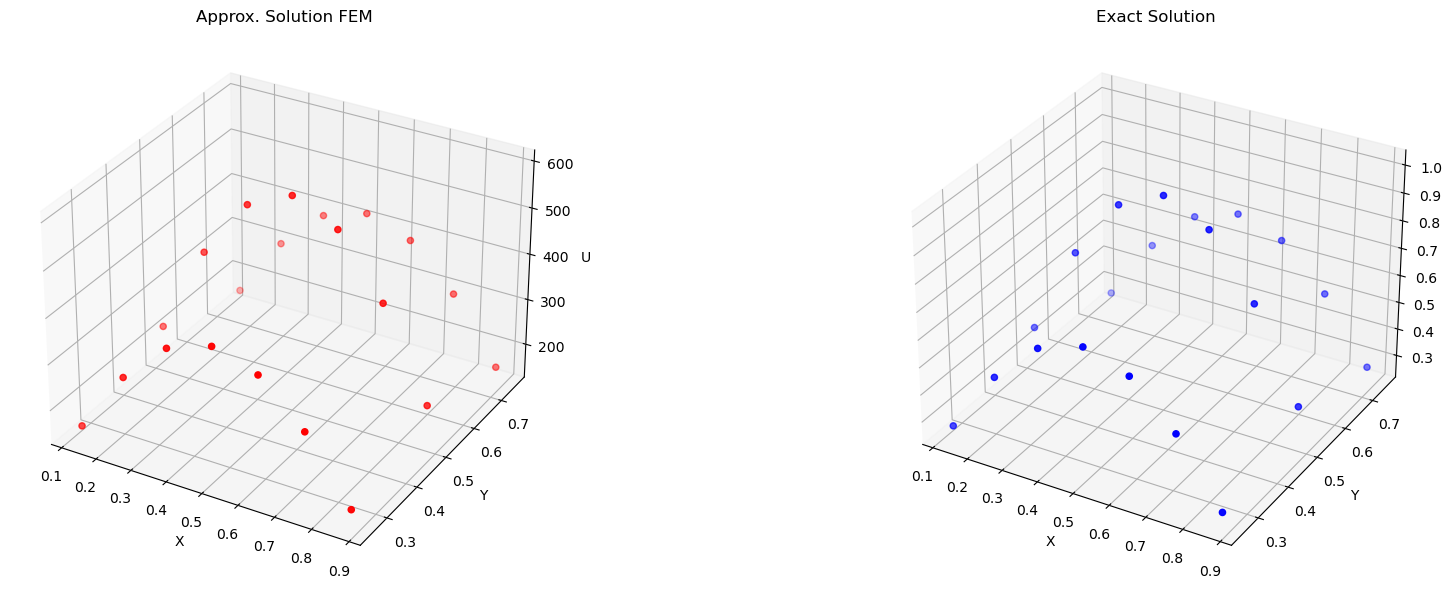

Error for mesh size 9: 1670.219589190656


In [ ]:
fig = plt.figure(figsize=(20,6))
non_boundary_nodes_coords = np.array([nodes[i] for i in non_boundary_nodes])

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(non_boundary_nodes_coords[:, 0], non_boundary_nodes_coords[:, 1],  u, color='r')
ax.set_title('Approx. Solution FEM')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('U')

# Grafico della soluzione esatta
ax = fig.add_subplot(1, 2, 2, projection='3d')
u_exact_values = np.array([u_exact(node) for node in non_boundary_nodes_coords])
ax.scatter(non_boundary_nodes_coords[:, 0], non_boundary_nodes_coords[:, 1],  u_exact_values, color='b')
ax.set_title('Exact Solution')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('U')
plt.tight_layout()
plt.show()

print(f"Error for mesh size {nx}: {error}")

### Step 5: Check Convergence:

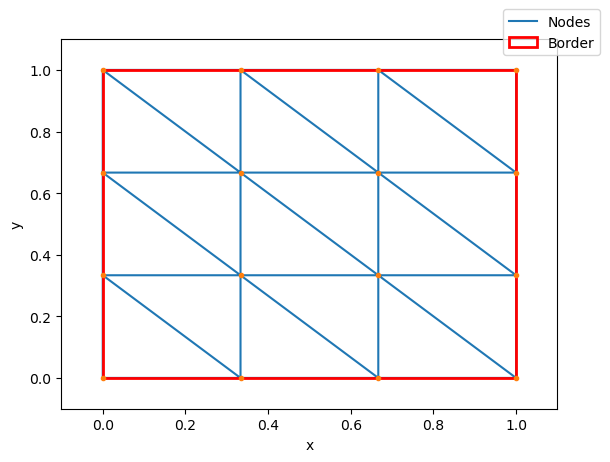

Relative Error: 141.21660366240695


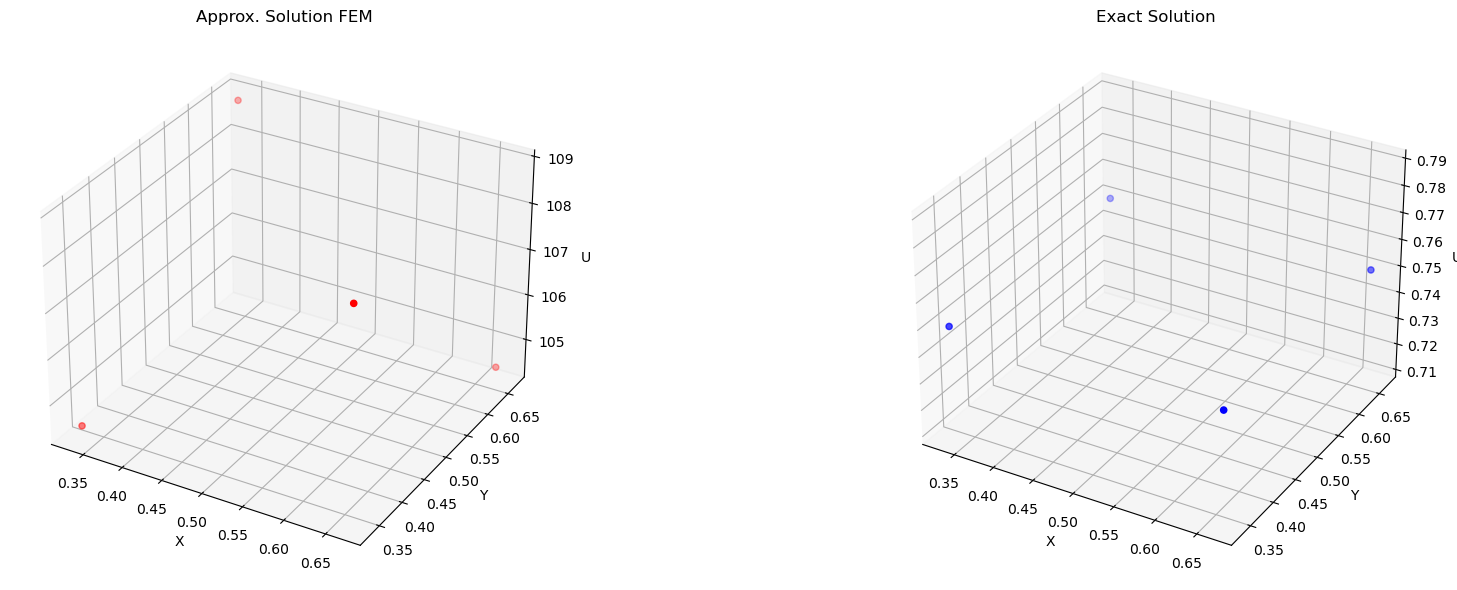

Errore per mesh 4: 141.21660366240695


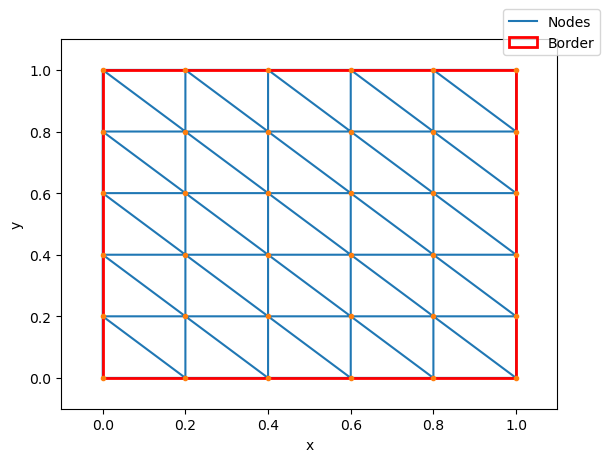

Relative Error: 463.94780863756506


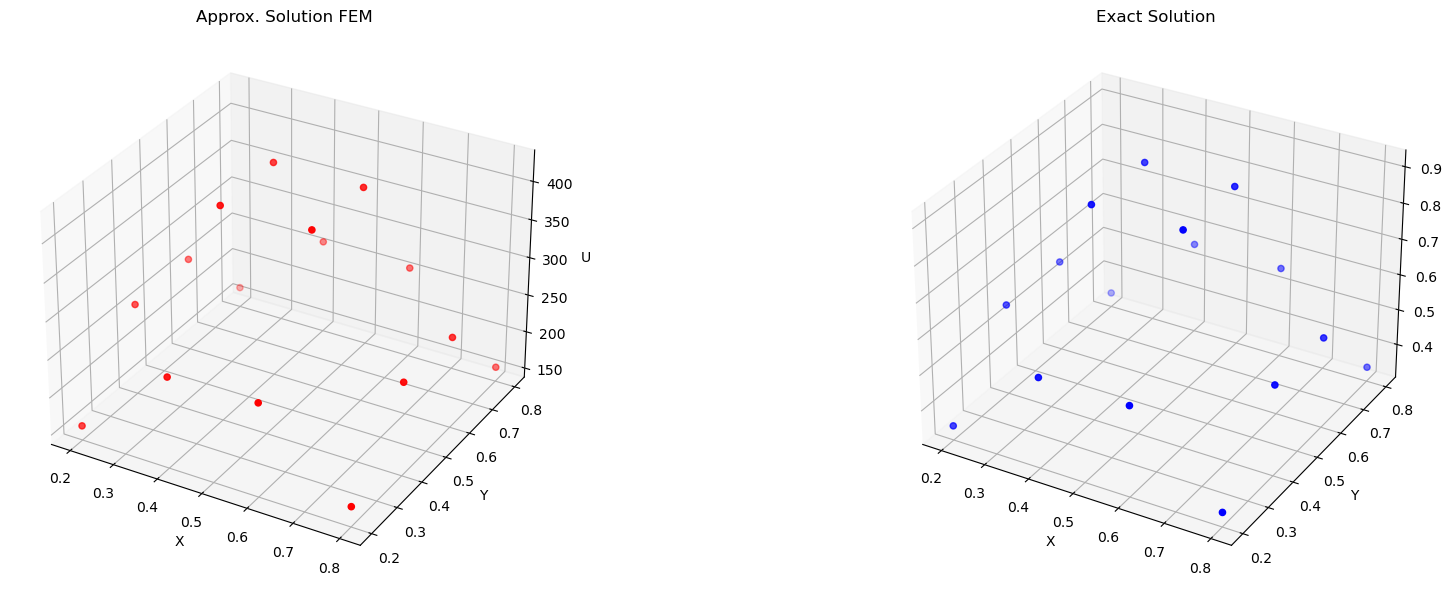

Errore per mesh 6: 463.94780863756506


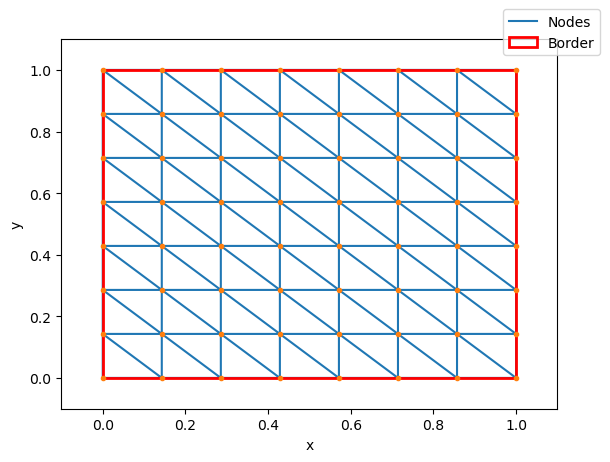

Relative Error: 941.4715640601527


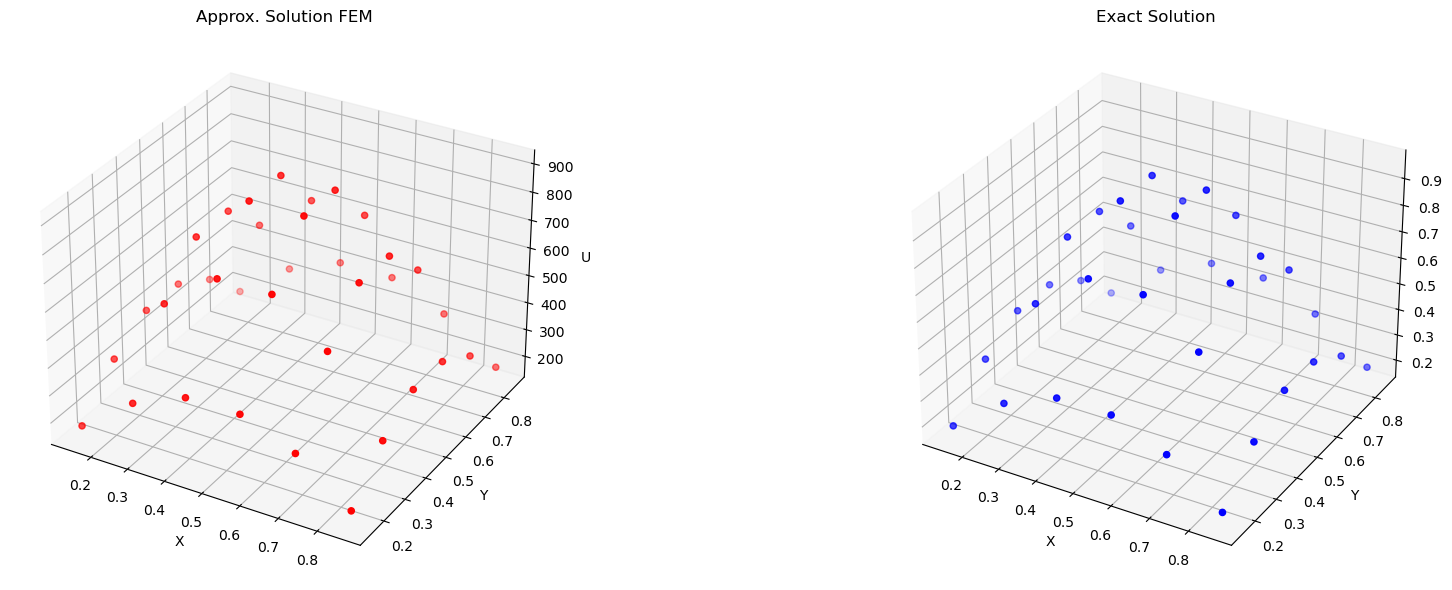

Errore per mesh 8: 941.4715640601527


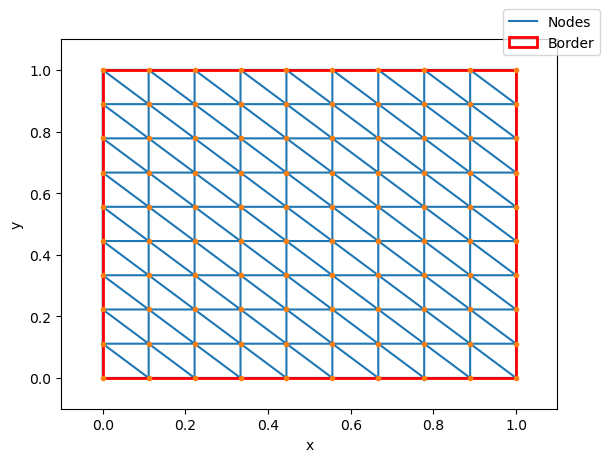

Relative Error: 1574.9730223923937


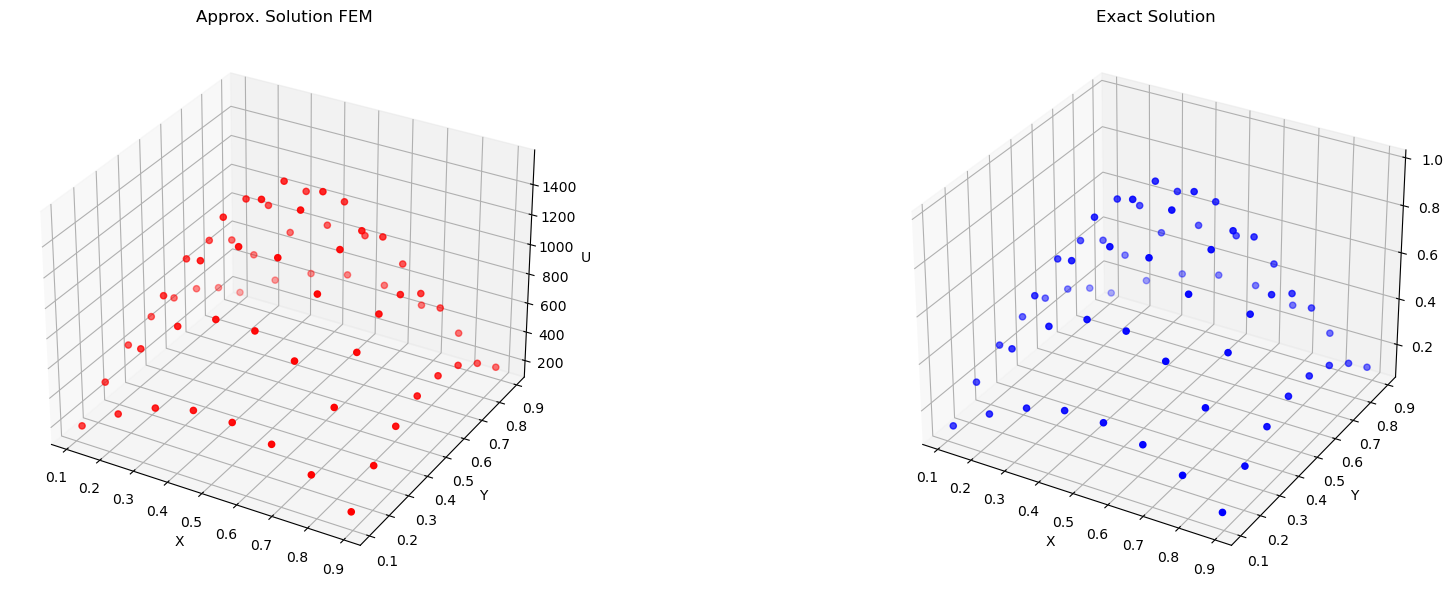

Errore per mesh 10: 1574.9730223923937


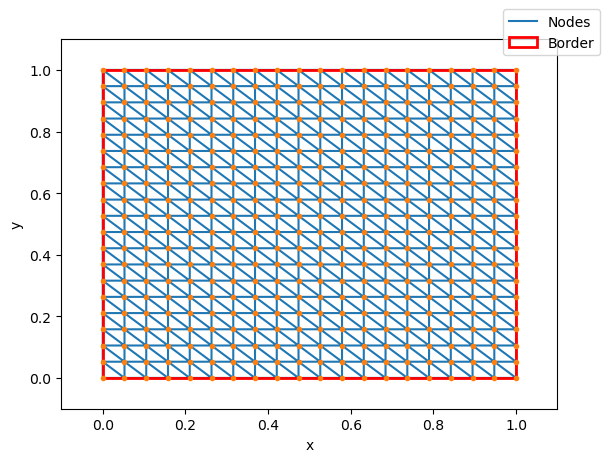

Relative Error: 7104.370290926627


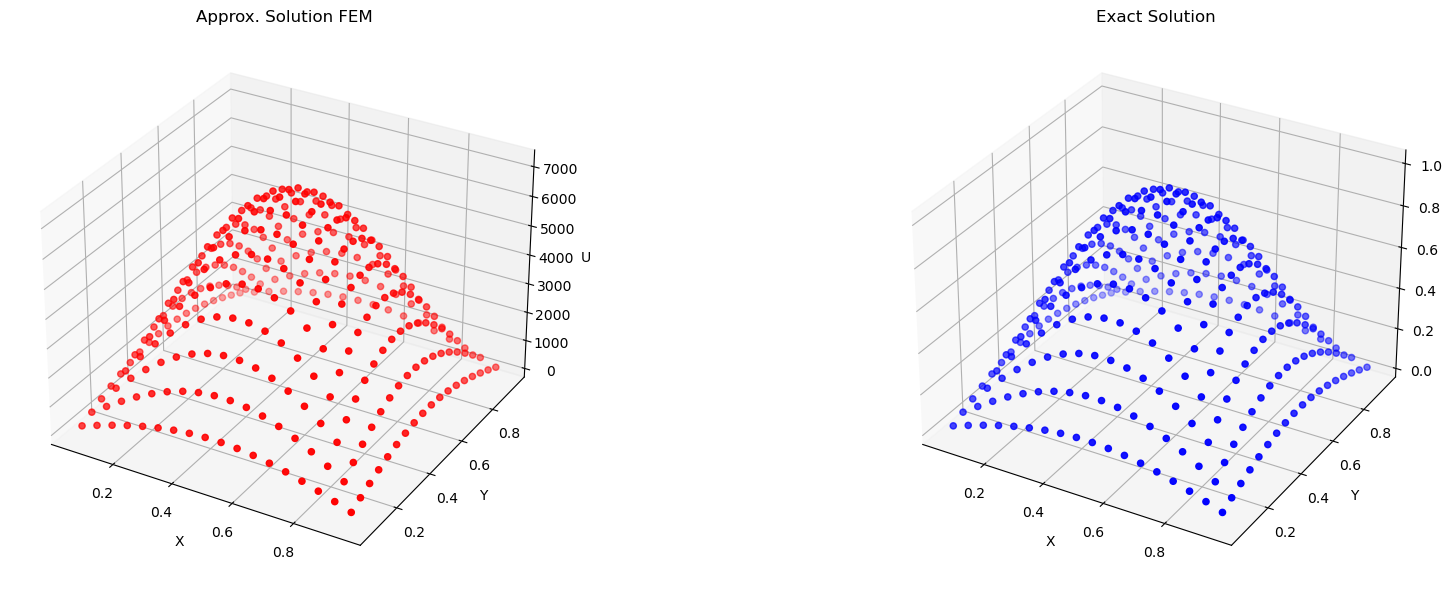

Errore per mesh 20: 7104.370290926627


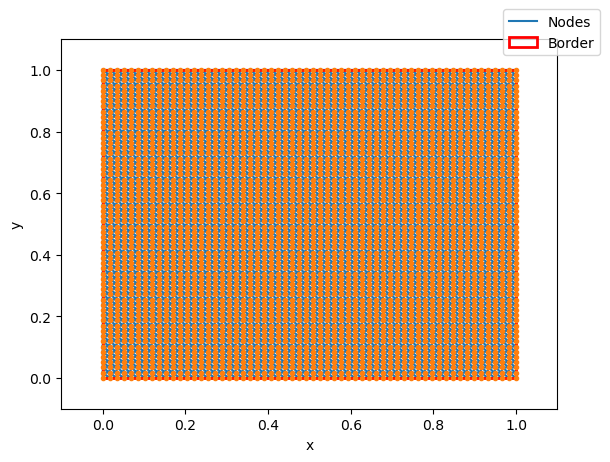

Relative Error: 68691.36845910747


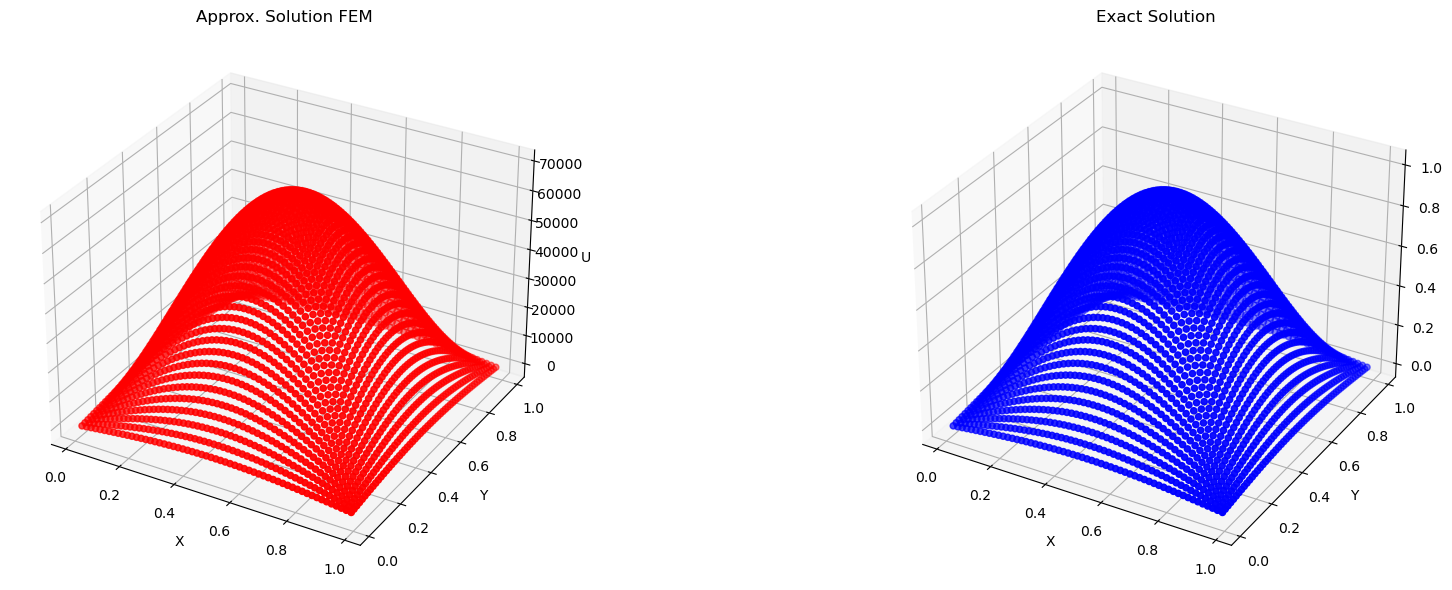

Errore per mesh 60: 68691.36845910747


In [65]:
mesh_sizes = [4, 6, 8, 10, 20, 60]  # Varie dimensioni della mesh
solutions = []

for size in mesh_sizes:
    nodes, elements = solver.create_rectangular_triangle_mesh(a, b, c, d, size, size)
    solver.plot_delaunay_mesh(nodes, elements)
    
    global_stiffness_matrix = solver.assemble_global_stiffness_matrix(elements,nodes,K_ref)
    
    
    boundary_nodes = solver.find_boundary_nodes(nodes,a,b,c,d)
    
    non_boundary_nodes = [i for i in range(len(nodes)) if i not in boundary_nodes]
    load_vector = solver.compute_load_vector(f, nodes)
    
    reduced_stiffness_matrix, reduced_load_vector = solver.apply_reduced_system_approach(global_stiffness_matrix, load_vector, boundary_nodes)
       
    u_approx = spsolve(reduced_stiffness_matrix, reduced_load_vector)  # Soluzione approssimata
    

    
    
    
    fig = plt.figure(figsize=(20,6))

    
    non_boundary_nodes_coords = np.array([nodes[i] for i in non_boundary_nodes])
    
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.scatter(non_boundary_nodes_coords[:, 0], non_boundary_nodes_coords[:, 1],  u_approx, color='r')
    ax.set_title('Approx. Solution FEM')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('U')

    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    u_exact_values = np.array([u_exact(node) for node in non_boundary_nodes_coords])
    ax.scatter(non_boundary_nodes_coords[:, 0], non_boundary_nodes_coords[:, 1],  u_exact_values, color='b')
    error = np.linalg.norm(u_approx - u_exact_values) / np.linalg.norm(u_exact_values)
    print("Relative Error:", error)
    ax.set_title('Exact Solution')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('U')
    plt.tight_layout()
    plt.show()
    
    print(f"Errore per mesh {size}: {error}")

# Conclusions

The case under examination revealed the presence of a bug in the calculation of the stiffness matrix that I have not been able to identify. In particular, it is observed that as the density of the mesh increases, the error between the approximate solution and the exact one also increases, whereas it should decrease for convergence. This is confirmed by comparing the graphs of the two functions.
**Likely, there is an error in the assembly of the global stiffness matrix.**